# start

In [1]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cmo
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cl
import gsw 

ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2024_n35.0_s-10.0_w25.0_e85.0.nc')

## functions_

In [2]:

def rolling_(df):
    lol=pd.DataFrame(df).interpolate(limit=5, axis=1).interpolate(limit=5, axis=0).rolling(1, center=True, axis=1).mean()
    return lol.to_numpy()


def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False, right=True)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False, right=True)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return (grid),XI.T,YI.T

def grid_(df, variable, taxis_, yaxis_):
    sig, xx, yy=grid2d(df.time.values, df.pressure.values, df[variable].values, xi=taxis_, yi=yaxis_)
    # sig=rolling_(sig)
    return sig, xx, yy

def era_to_PWP(ds_era):
    era5_=ds_era.rename_vars({'mslhf':'qlat', 'msnswrf':'sw', 'msnlwrf':'lw', 'msshf':'qsens'})
    def tau_(speed_u):
        # U=(speed_u**2+speed_v**2)**(0.5)
        Cd = 0.001*(1.1 + 0.035*speed_u)
        rho_air=1.225
        tau=rho_air*Cd*speed_u
        return tau
    era5_['tx']=tau_(era5_['u10'])
    era5_['ty']=tau_(era5_['v10'])
    era5_['precip']= era5_.mtpr/1000
    era5_['evap']= era5_.mer/1000
    #(era5_.mtpr-era5_.mer)/1000
    era5_=era5_.drop_vars([ 'sst',  'u10', 'v10', 'mer', 'mtpr',  'sp'])
    
    return era5_

import gsw

def float_profile(float_ds, time_sel,name, save=True):
    floattprofile=float_ds.sel(time=time_sel, method='nearest')

    daf_g = xr.Dataset(
        data_vars=dict(
            s=("z",floattprofile.salinity.rolling(pressure=3,center=True).mean().bfill('pressure').ffill('pressure').values ),
            t=("z",floattprofile.temperature.rolling(pressure=3,center=True).mean().bfill('pressure').ffill('pressure').values ),
            lat=(13)
        ),
        coords=dict(
            z=df_arg.pressure.values,
        ),)
    if save==True:
        daf_g.to_netcdf('input_data/'+name+'.nc')
    return daf_g
        
import glidertools as gt

def mixed_layer(pwp_out_, thre, rdp, pwp=True):
    if pwp==True:
        pres= pwp_out_['z']
        XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
        mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['potential_density'].flatten(), ref_depth=rdp, thresh=thre)
    else:
        pres= pwp_out_['pressure'].values
        XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
        mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['potential_density'].values.flatten(), ref_depth=rdp, thresh=thre)

    return mld

def barrier_layer(pwp_out_, thre=0.2, rdp=10, pwp=True):
    if pwp==True:
        pres= pwp_out_['z']
        XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
        mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['cons_temp'].flatten(), ref_depth=rdp, thresh=thre)
    else:
        pres= pwp_out_['pressure'].values
        XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
        mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['cons_temp'].values.flatten(), ref_depth=rdp, thresh=thre)

    return mld


def n_squa(dff, pwp=True):
    if pwp==True:
        pres= dff['pressure']
        # XX, YY = np.meshgrid(np.arange(0,len(dff['time']), 1),  pres)
        # n2=gsw.Nsquared(dff['abs_salinity'], dff['cons_temp'], YY)[0] 
        
    else:
        pres= dff['pressure'].values
    XX, YY = np.meshgrid(np.arange(0,len(dff['time']), 1),  pres)
    n2=gsw.Nsquared(dff['abs_salinity'].values, dff['cons_temp'].values, YY)[0] 
    return n2




GS=1
latt=np.arange(-5,30+GS,GS)
lonn=np.arange(30,80+GS,GS)
# grid 3d for 3d variables (2d + time)

## grid pwp sum
def grid_lat_3dsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')

def grid_lon_3d_sum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dsum)
    
    
def grid_var_3dsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_sum)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_sum)
    return var


## grid pwp sum
def grid_lat_3d(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')

def grid_lon_3d_(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3d)
    
    
def grid_var_3d(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'all':
        var = dsvar.apply(grid_lon_3d_)
    elif clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_)
    return var

## GRID 3d 4d
# def mode_func(array):
#     mode_result = stats.mode(array, axis=None)
#     return mode_result.mode[0]

# grid 3d for 3d variables (2d + time)
def grid_lat_3df(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_f(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3df)
    
    
def grid_var_3dflt(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_f)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_f)
    return var


# grid 3d for 3d variables (2d + time)
def grid_lat_3dfsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_fsum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dfsum)
    
    
def grid_var_3dfltsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_fsum)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_fsum)
    return var

# LOAD DATA

In [3]:
df_arg=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/argo_wwl_per_yr/L0/argo_wwl_0_578floats.nc')
for i in list(df_arg.variables):
    df_arg=df_arg.rename({i:i+'_f'})    
df_arg=df_arg.rename({'N2_f':'n2_f','N2_roll_f':'n2_roll_f', 'min_n2_f':'min_n2_depth_f'})

def center_properties(dff,variablee):
    dff['core_'+variablee]=dff[variablee].sel(pressure_f=dff.min_n2_depth_f.fillna(0))*((dff.min_n2_depth_f/dff.min_n2_depth_f))

df_era=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/ERA5_collocated/ERA5_collocated_to_df_arg_1day.nc')

# Compute forcings:) 

In [4]:
df_arg=xr.merge([df_arg.sortby('platform_num_f'), df_era.sortby('platform_num_f')])

df_arg['latitude_era']=df_arg.latitude_f.mean('pressure_f').rename({'time_f':'time'}).interp_like('time_f'==df_arg.time).interpolate_na('time',method='linear', max_gap=pd.Timedelta('15D'))
df_arg['longitude_era']=df_arg.longitude_f.mean('pressure_f').rename({'time_f':'time'}).interp_like('time_f'==df_arg.time).interpolate_na('time',method='linear', max_gap=pd.Timedelta('15D'))

def B(ds_s):
    # ds=df.resample(time='1d').mean()
    dtempsal=ds_s[['abs_salinity_f', 'cons_temp_f']].where(ds_s.pressure_f<20, drop=True).median('pressure_f').rename({'time_f':'time'}).interp_like('time'==ds_s.time, method='linear')
    sal_=dtempsal.abs_salinity_f
    temp_=dtempsal.cons_temp_f
    dalpha=gsw.alpha(sal_, temp_, 0)
    dbeta=gsw.beta(sal_, temp_, 0)
        
    qnet_=(ds_s.sw+ds_s.lw+ds_s.qlat+ds_s.qsens).T
    ep=(ds_s.evap+ds_s.precip).T/1000  # evap is negative, precip is postiive... if e+p is >0--> precipitation, add buoy!

    cp0= 3991.86795711963
    g=9.8
    rho0=1027

    d_thermal=(dalpha*qnet_)/(rho0*cp0)
    d_haline=(dbeta*sal_*ep)

    ds_s['B']=g*(d_thermal+d_haline)
    ds_s['B_thermal']=g*d_thermal
    ds_s['B_haline']=g*d_haline
    
#     return ds_s[['B','B_thermal', 'B_haline']]

B(df_arg)

df_arg['Q_net']=(df_arg.sw+df_arg.lw+df_arg.qlat+df_arg.qsens).T
df_arg['P-E']=(df_arg.evap+df_arg.precip).T
df_arg['tau']=np.sqrt(df_arg.tx**2+df_arg.ty**2).T

In [5]:
## Grid hovmoler

In [6]:
XX, YY=np.meshgrid(np.arange(0,len(df_arg.time_f)), df_arg.platform_num_f)
swr=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.sw.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='median')[0]
lwr=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.lw.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='median')[0]
shf=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.qsens.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='median')[0]
lhf=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.qlat.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='median')[0]

Qnet=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.Q_net.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]
tau=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.tau.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]
ep=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg['P-E'].sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]

u=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.tx.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]
v=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.ty.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]

BB=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.B.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]
BBT=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.B_thermal.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]
BBS=grid2d(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.B_haline.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1), fn='mean')[0]

# udir=grid2dcirc(df_arg.latitude_era.sel(time=df_arg.time_f).values.flatten(), XX.flatten(), df_arg.U_direction.sel(time=df_arg.time_f).values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(df_arg.time_f), 1))[0]


qnet_per_lat= xr.Dataset(
    data_vars=dict(
        qnet=(["time", "latitude"], Qnet),  
        tau=(["time", "latitude"], tau),   
        B=(["time", "latitude"], BB),        
        Btherm=(["time", "latitude"], BBT),        
        Bhal=(["time", "latitude"], BBS),        
        
        ep=(["time", "latitude"], ep),        
        u=(["time", "latitude"], u),        
        v=(["time", "latitude"], v), 
        sswr=(["time", "latitude"], swr), 
        llwr=(["time", "latitude"], lwr),
        sshf=(["time", "latitude"], shf),
        llhf=(["time", "latitude"], lhf)),
    coords=dict(
        latitude=np.arange(0,30,0.5),
        time=df_arg.time_f.values,
    ),)


In [7]:
## SUPL FIGURE FORCING

/tmp/ipykernel_645658/4093712889.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().B.T,colors='k',levels=[0], label='B=0')
/tmp/ipykernel_645658/4093712889.py:25: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().B.T+qnet_per_lat.groupby('time.dayofyear').std().B.T, linestyles=[':'], colors='k',levels=[0], label='B+1std=0')
/tmp/ipykernel_645658/4093712889.py:26: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().B.T-

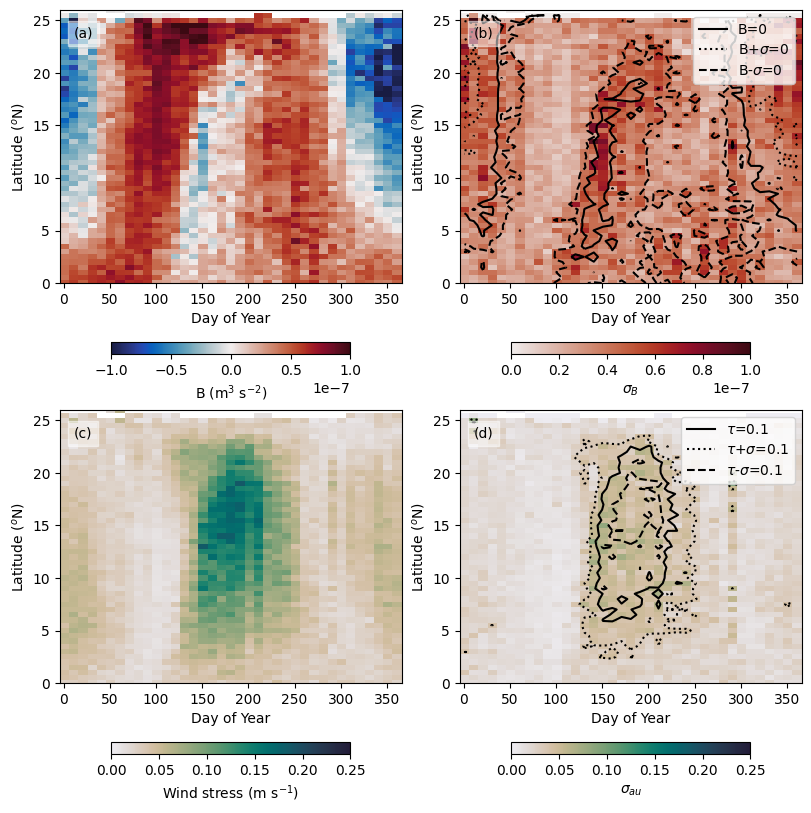

In [10]:
plt.figure(figsize=(8,8), constrained_layout=True)
alp=0.5
ax=plt.subplot(221)
t=ax.text(x=.04,y=.9,s='(a)',transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().B.T, vmin=-1e-7, vmax=1e-7, cmap=cmo.balance)
cb=plt.colorbar(shrink=.7, orientation='horizontal')
cb.set_label('B (m$^{3}$ s$^{-2}$)')
# plt.yticks([])
plt.ylabel('Latitude ($^o$N)')
plt.ylim(0,26)
plt.xlabel('Day of Year')
# plt.contour(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, (per1)*100, levels=[50], colors=['w'], linestyles=[':'])


ax=plt.subplot(222)
t=ax.text(x=.04,y=.9,s='(b)',transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').std().B.T, vmin=0, vmax=1e-7, cmap=cmo.amp)
cb=plt.colorbar(shrink=.7, orientation='horizontal')
cb.set_label('$\sigma_B$')
# plt.yticks([])
plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().B.T,colors='k',levels=[0], label='B=0')
plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().B.T+qnet_per_lat.groupby('time.dayofyear').std().B.T, linestyles=[':'], colors='k',levels=[0], label='B+1std=0')
plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().B.T-qnet_per_lat.groupby('time.dayofyear').std().B.T,  linestyles=['--'], colors='k', levels=[0], label='B-1std=0')
plt.ylabel('Latitude ($^o$N)')
plt.ylim(0,26)
plt.xlabel('Day of Year')
plt.plot([2,2,3], [3,3,3],c='k', label='B=0')
plt.plot([2,2,3], [3,3,3], c='k', ls=':',label='B+$\sigma$=0')
plt.plot([2,2,3], [3,3,3], c='k', ls='--', label='B-$\sigma$=0')

plt.legend()


ax=plt.subplot(223)
t=ax.text(x=.04,y=.9,s='(c)',transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T, vmin=0, vmax=0.25, cmap=cmo.rain)
cb=plt.colorbar(shrink=.7, orientation='horizontal')
cb.set_label('Wind stress (m s$^{-1}$)')
# plt.yticks([])
plt.ylabel('Latitude ($^o$N)')
plt.ylim(0,26)
plt.xlabel('Day of Year')
# plt.contour(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, (per1)*100, levels=[50], colors=['w'], linestyles=[':'])


ax=plt.subplot(224)
t=ax.text(x=.04,y=.9,s='(d)',transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').std().tau.T, vmin=0, vmax=0.25, cmap=cmo.rain)
cb=plt.colorbar(shrink=.7, orientation='horizontal')
cb.set_label('$\sigma_{\tau}$')
# plt.yticks([])
plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T,colors='k',levels=[0.1], label='$\tau$=0')
plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T+qnet_per_lat.groupby('time.dayofyear').std().tau.T, linestyles=[':'], colors='k',levels=[0.1], label='B+1std=0')
plt.contour(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T-qnet_per_lat.groupby('time.dayofyear').std().tau.T,  linestyles=['--'], colors='k', levels=[0.1], label='B-1std=0')
plt.ylabel('Latitude ($^o$N)')
plt.ylim(0,26)
plt.xlabel('Day of Year')
plt.plot([2,2,3], [3,3,3],c='k', label=r'$\tau$=0.1')
plt.plot([2,2,3], [3,3,3], c='k', ls=':',label=r'$\tau$+$\sigma$=0.1')
plt.plot([2,2,3], [3,3,3], c='k', ls='--', label=r'$\tau$-$\sigma$=0.1')

plt.legend()


plt.savefig('Figures/SFigure_B_tau_std.png', dpi=600, bbox_inches='tight')

Text(0.5, 0, 'Day of Year')

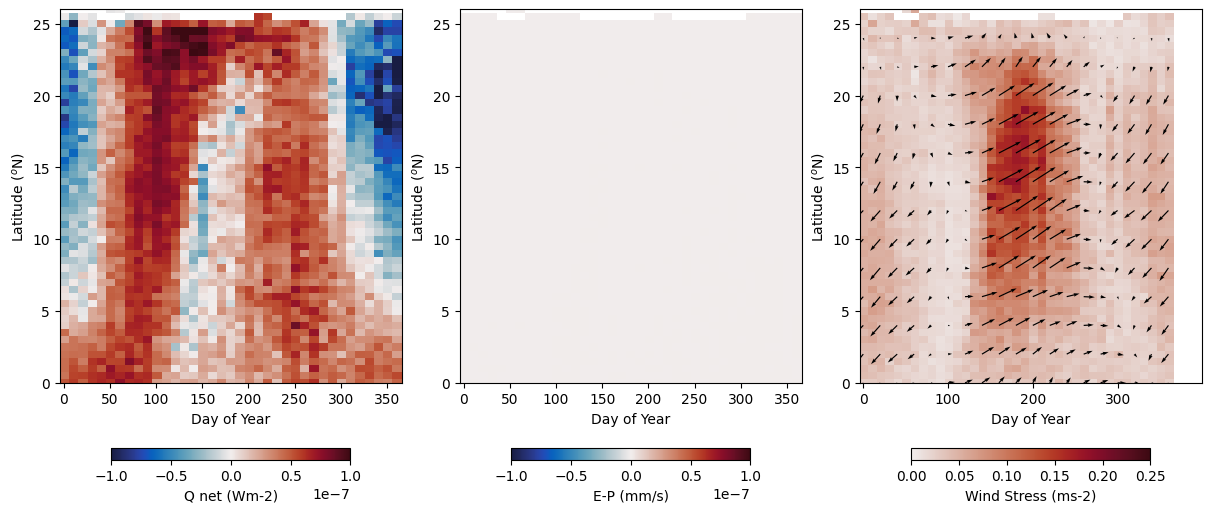

In [9]:
# other assesment forcing figures extra

plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(131)

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().Btherm.T, vmin=-1e-7, vmax=1e-7,  cmap=cmo.balance)
cb=plt.colorbar(shrink=.7, orientation='horizontal')
cb.set_label('Q net (Wm-2)')
# plt.yticks([])
plt.ylabel('Latitude ($^o$N)')
plt.ylim(0,26)
plt.xlabel('Day of Year')
# plt.contour(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, (per1)*100, levels=[50], colors=['w'], linestyles=[':'])


plt.subplot(132)

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().Bhal.T, vmin=-1e-7, vmax=1e-7,cmap=cmo.balance)
cb=plt.colorbar(shrink=.7, orientation='horizontal')
cb.set_label('E-P (mm/s)')
# plt.yticks([])
plt.ylabel('Latitude ($^o$N)')
plt.ylim(0,26)
plt.xlabel('Day of Year')


plt.subplot(133)

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T, vmin=0, vmax=0.25, cmap=cmo.amp)
cb=plt.colorbar(shrink=.7, orientation='horizontal')
cb.set_label('Wind Stress (ms-2)')

df_arg['lat_pp']=df_arg.latitude_era.mean('time')

dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).u10.groupby('time.dayofyear').mean()
dfls=dfls.sortby(dfls.lat_pp)

XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
grid_udiru=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]


dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).v10.groupby('time.dayofyear').mean().sortby(dfls.lat_pp)

XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
grid_udirv=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]
plt.quiver( np.arange(0,365+20, 20), np.arange(0,30,2), grid_udiru, grid_udirv)

# plt.yticks([])
plt.ylabel('Latitude ($^o$N)')
plt.ylim(0,26)
plt.xlabel('Day of Year')



In [11]:
# plt.figure(figsize=(12,5), constrained_layout=True)

# plt.subplot(131)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().qnet.T, vmin=-200, vmax=200, cmap=cmo.balance)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('Q net (Wm-2)')
# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')
# # plt.contour(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, (per1)*100, levels=[50], colors=['w'], linestyles=[':'])


# plt.subplot(132)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, -qnet_per_lat.groupby('time.dayofyear').mean().ep.T, vmin=-1e-7, vmax=1e-7, cmap=cmo.balance)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('E-P (mm/s)')
# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')


# plt.subplot(133)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T, vmin=0, vmax=0.25, cmap=cmo.amp)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('Wind Stress (ms-2)')

# df_arg['lat_pp']=df_arg.latitude_era.mean('time')

# dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).u10.groupby('time.dayofyear').mean()
# dfls=dfls.sortby(dfls.lat_pp)

# XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
# grid_udiru=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]


# dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).v10.groupby('time.dayofyear').mean().sortby(dfls.lat_pp)

# XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
# grid_udirv=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]
# plt.quiver( np.arange(0,365+20, 20), np.arange(0,30,2), grid_udiru, grid_udirv)

# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')



In [12]:
# plt.figure(figsize=(12,5), constrained_layout=True)

# plt.subplot(131)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().sswr.T, vmin=-200, vmax=200, cmap=cmo.balance)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('Q net (Wm-2)')
# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')
# # plt.contour(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, (per1)*100, levels=[50], colors=['w'], linestyles=[':'])


# plt.subplot(132)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().llwr.T, vmin=-200, vmax=200, cmap=cmo.balance)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('E-P (mm/s)')
# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')


# plt.subplot(133)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T, vmin=0, vmax=0.25, cmap=cmo.amp)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('Wind Stress (ms-2)')

# df_arg['lat_pp']=df_arg.latitude_era.mean('time')

# dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).u10.groupby('time.dayofyear').mean()
# dfls=dfls.sortby(dfls.lat_pp)

# XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
# grid_udiru=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]


# dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).v10.groupby('time.dayofyear').mean().sortby(dfls.lat_pp)

# XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
# grid_udirv=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]
# plt.quiver( np.arange(0,365+20, 20), np.arange(0,30,2), grid_udiru, grid_udirv)

# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')



In [13]:
# plt.figure(figsize=(12,5), constrained_layout=True)

# plt.subplot(131)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().sshf.T, vmin=-200, vmax=200, cmap=cmo.balance)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('Q net (Wm-2)')
# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')
# # plt.contour(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, (per1)*100, levels=[50], colors=['w'], linestyles=[':'])


# plt.subplot(132)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().llhf.T, vmin=-200, vmax=200, cmap=cmo.balance)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('E-P (mm/s)')
# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')


# plt.subplot(133)

# plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude, qnet_per_lat.groupby('time.dayofyear').mean().tau.T, vmin=0, vmax=0.25, cmap=cmo.amp)
# cb=plt.colorbar(shrink=.7, orientation='horizontal')
# cb.set_label('Wind Stress (ms-2)')

# df_arg['lat_pp']=df_arg.latitude_era.mean('time')

# dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).u10.groupby('time.dayofyear').mean()
# dfls=dfls.sortby(dfls.lat_pp)

# XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
# grid_udiru=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]


# dfls=df_arg.set_coords('lat_pp').swap_dims({'platform_num_f':'lat_pp'}).v10.groupby('time.dayofyear').mean().sortby(dfls.lat_pp)

# XX, YY = np.meshgrid(dfls.dayofyear, dfls.lat_pp)
# grid_udirv=grid2d(XX.flatten(), YY.flatten(), dfls.T.values.flatten(),xi=np.arange(0,365+20, 20), yi=np.arange(0,30,2))[0]
# plt.quiver( np.arange(0,365+20, 20), np.arange(0,30,2), grid_udiru, grid_udirv)

# # plt.yticks([])
# plt.ylabel('Latitude ($^o$N)')
# plt.ylim(0,26)
# plt.xlabel('Day of Year')



# MW thickness for all floats + week and monthly climatology

In [14]:
dff_=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/thickness_mw.nc')
dff_=dff_.set_coords(['latitude_f', 'longitude_f'])

# df_mld=ds_get_float_pwp_1D('mixed_layer_depth')
# df_mld=df_mld.set_coords(['latitude_f', 'longitude_f'])
df_mld=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/mld.nc').set_coords(['latitude_f', 'longitude_f'])
# dff_presence=ds_get_float_pwp_1D('presence_mwl')
df_presence=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/presence_mw.nc')
df_presence=df_presence.sortby('platform_num_f')

df_presence['lat_pp']=df_presence.latitude_f.mean('time_f')
df_presence['lon_pp']=df_presence.longitude_f.mean('time_f')

## only foramtion
dff_presence_1 = df_presence.where(df_presence != 0, np.nan)
dff_presence_1 = dff_presence_1.where(df_presence != 2, np.nan)

## only duration
dff_presence_2 = df_presence.where(df_presence != 0, np.nan)
dff_presence_2 = dff_presence_2.where(df_presence != 1, np.nan)
dff_presence_2 = dff_presence_2.where(df_presence !=2, 1)

# no mode water
dff_presence_0 = df_presence.where(df_presence != 1, np.nan)
dff_presence_0 = dff_presence_0.where(df_presence != 2, np.nan)
dff_presence_0 = dff_presence_0.where(df_presence!=0, 1)


mask_pres=((dff_presence_0.presence_mwl_f.fillna(0).values+dff_presence_1.presence_mwl_f.fillna(0).values)==1).astype(float)
mask_pres[mask_pres==0]=np.nan

mask_thic=(dff_.mw_thickness_f>10).values.astype(float)
mask_thic[mask_thic==0]=np.nan


In [15]:
df_grid_thickness_f=grid_var_3dflt(dff_.mw_thickness_f*mask_pres*mask_thic, clim='week', gs=GS) ##30sec

df_grid_thickness_fmtnh=grid_var_3dflt(dff_.mw_thickness_f*mask_pres*mask_thic, clim='month', gs=GS) ##3min

/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


#### plot

  0%|          | 0/12 [00:00<?, ?it/s]

(0.0, 6.283185307179586, 0.0, 1.0)

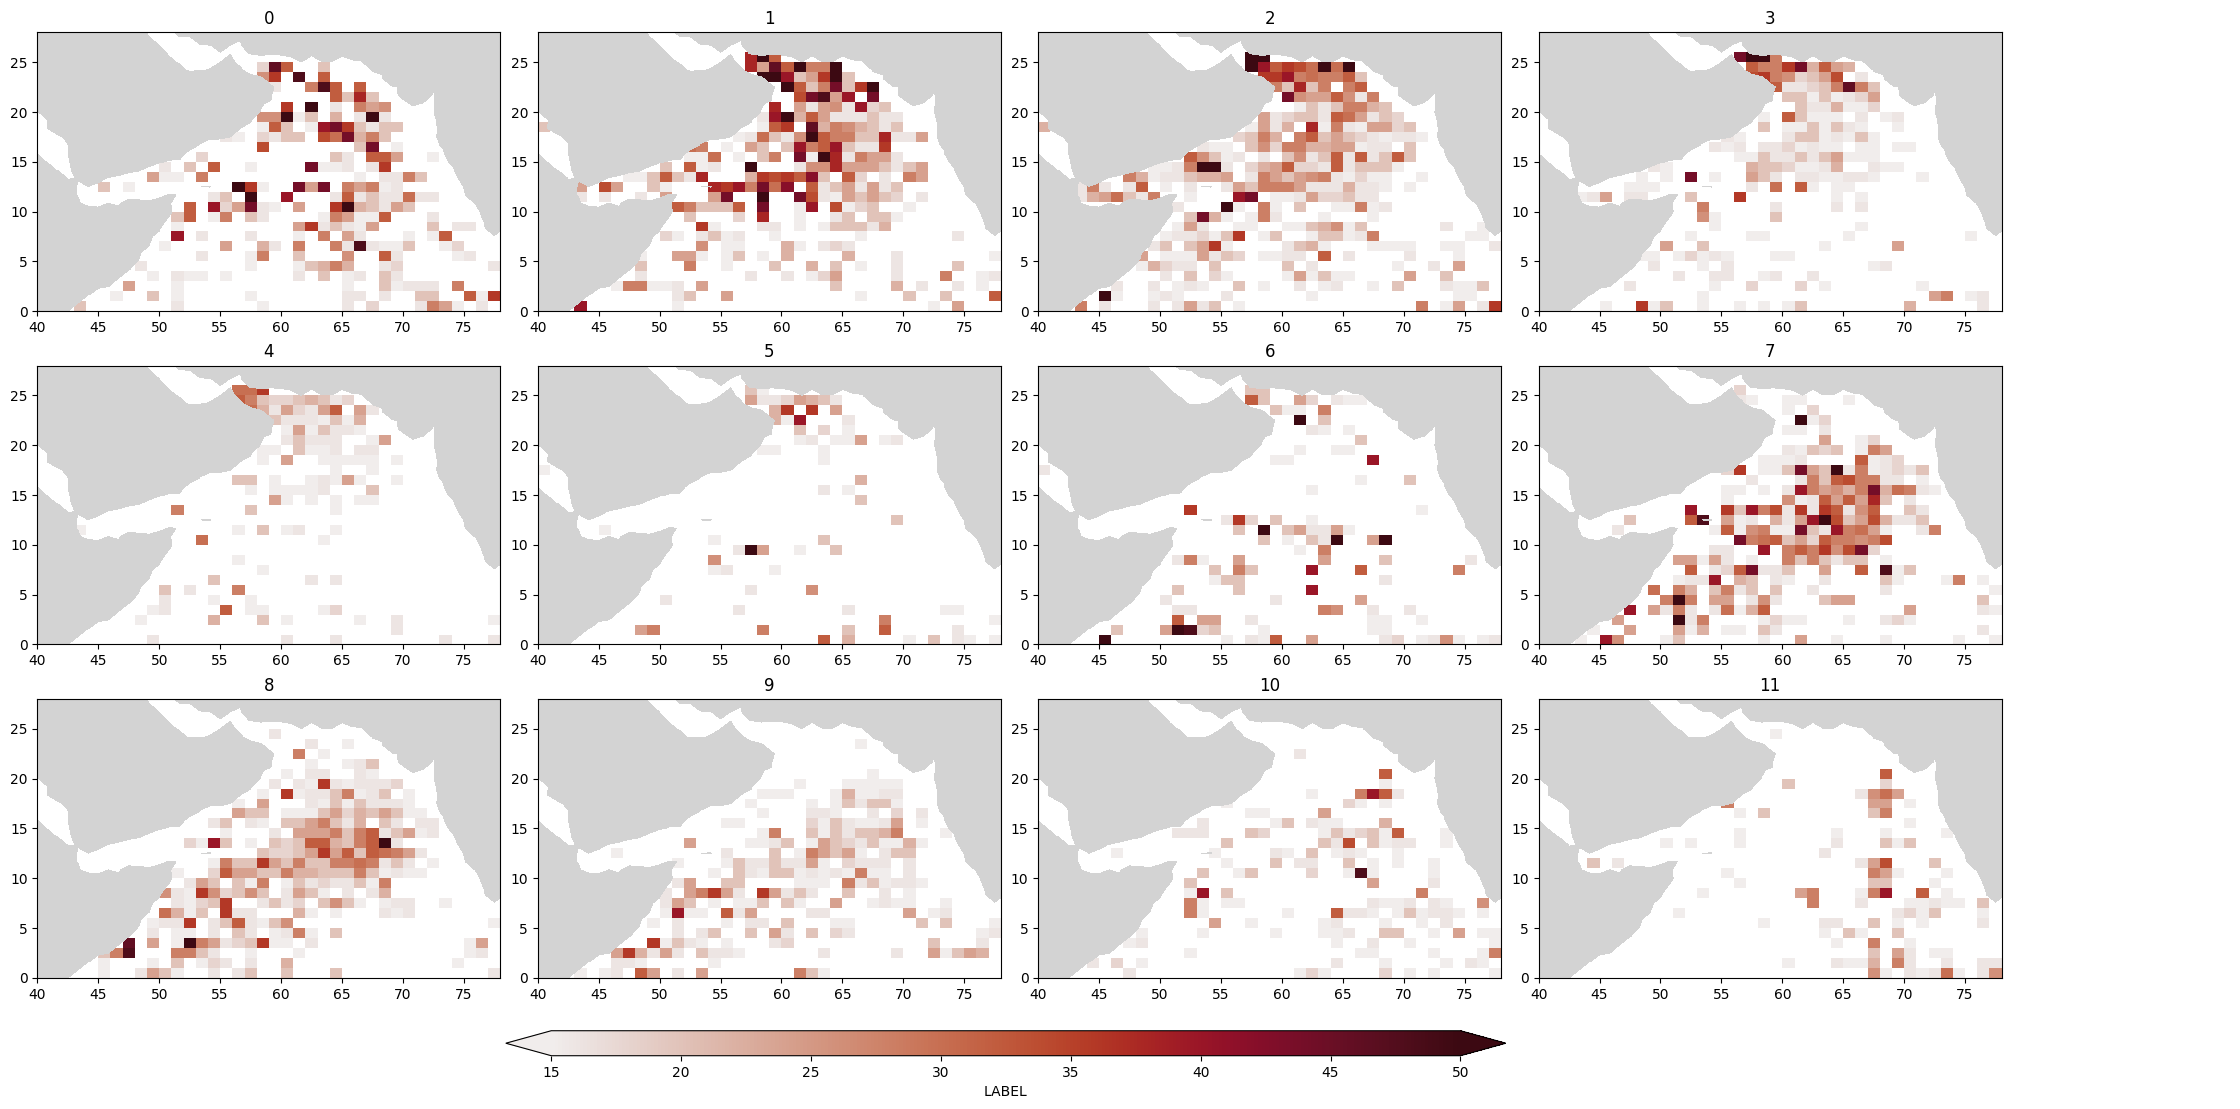

In [25]:
xx,yy=3,4
fig_sx, fig_sy=20, 10

fig = plt.figure(figsize=(fig_sx, fig_sy), constrained_layout=True)
gs = GridSpec(xx,yy, figure=fig)
data_plt=df_grid_thickness_fmtnh

for i in tqdm(range(xx*yy)):
    ax = fig.add_subplot(gs[i // yy, i % yy])
    data_m=data_plt[i]
    ax.set_title(str(i))    
    cb=ax.pcolormesh(lonn, latt, data_m.T, vmin=15, vmax=50, cmap=cmo.amp)
    # ax.contourf(np.arange(40,76,1), np.arange(0,28,1), grid2d(data_m.longitude.values.flatten(), data_m.latitude.values.flatten(), data_m.values.flatten(), xi=np.arange(40,76,1), yi=np.arange(0,28,1))[0], levels=[VMIN, VAX_], colors='green', alpha=0.9)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='lightgray')
    ax.set_xlim(40,78)
    ax.set_ylim(0,28)

cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.025])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('LABEL')

ax = plt.axes([1, 0.5-0.15/2, 0.15, 0.15], polar=True)#,  bbox=dict(facecolor='white', alpha=0.8))
plt.axis('off')

# Presence of MW + duration

In [16]:
dff_presence=df_presence.copy()

In [17]:
## length duration
def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False, right=True)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False, right=True)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return grid,XI.T,YI.T


def get_length_of_periods_with_ones(dff_presence, platnum):
    # try_=dff_presence.where(dff_presence != 0, 1)
    timeseries=dff_presence.where(dff_presence == 1, np.nan).isel(platform_num_f=platnum).presence_mwl_f
    # Ensure timeseries is a numpy array and handle NaNs by filling with a value other than 1
    values = timeseries.values
    mask = np.isnan(values)
    filled_values = np.where(mask, -1, values)
    
    # Identify where the value changes occur
    changes = np.diff(filled_values, prepend=filled_values[0])
    starts = np.where((filled_values == 1) & (np.roll(filled_values, 1) != 1))[0]
    ends = np.where((filled_values != 1) & (np.roll(filled_values, 1) == 1))[0]

    if len(starts) == 0:
        return []

    # Handle edge case if the last value is part of a 1-period
    if len(ends) == 0 or ends[-1] < starts[-1]:
        ends = np.append(ends, len(values))

    # Calculate lengths of periods with 1s
    lengths = ends - starts

    return starts, ends, lengths

def average_latitudelongitude_for_periods(starts, ends, latitude):
    average_latitudes = []
    for start, end in zip(starts, ends):
        avg_lat = latitude[start:start+3].mean().item()        
        average_latitudes.append(avg_lat)
    return average_latitudes

def max_thicn_for_periods(starts, ends, latitude):
    average_latitudes = []
    for start, end in zip(starts, ends):
        if len(latitude[start:end])==0:
            avg_lat=np.nan
        else:
            avg_lat = np.nanmax(latitude[start:end].values)        
        average_latitudes.append(avg_lat)
    return average_latitudes

def speed_erosion_for_periods(starts, ends, latitude):
    average_latitudes = []
    for start, end in zip(starts, ends):
        if len(latitude[start:end])<5:
            avg_lat=np.nan
        else:
            # plt.plot(latitude[start:end])
            # plt.show()
            dif=np.diff(latitude[start:end].values)
            lol=dif[dif<0]
            avg_lat = np.nanmedian(-lol)        
        average_latitudes.append(avg_lat)
    return average_latitudes

length,thinkes,  speed, timestart, av_lat, av_lon=[],[],[],[],[],[]
for i in tqdm(range(len(dff_presence.platform_num_f))):
    dss=dff_presence.isel(platform_num_f=i)
    dsslol=dff_.mw_thickness_f.isel(platform_num_f=i)
    
    lengths_st = get_length_of_periods_with_ones(dff_presence, i)
    if len(lengths_st)>1:
        length.append(lengths_st[2]*10)
        thinkes.append(max_thicn_for_periods(lengths_st[0], lengths_st[1], dsslol))
        speed.append(speed_erosion_for_periods(lengths_st[0], lengths_st[1], dsslol))
        
        timestart.append(dss.time_f[lengths_st[0]+1].values)
        # timesend.append(dss.time_f[lengths_st[0]].values)
        av_lat.append(average_latitudelongitude_for_periods(lengths_st[0], lengths_st[1], dss.latitude_f))
        av_lon.append(average_latitudelongitude_for_periods(lengths_st[0], lengths_st[1], dss.longitude_f))

df_length_mwl= xr.Dataset(
    data_vars=dict(
        length=("time",  np.concatenate(length)),
        latitude=("time",  np.concatenate(av_lat)),
        longitude=("time",  np.concatenate(av_lon)),
        thickness=("time", np.concatenate(thinkes) ), 
        speed=("time", np.concatenate(speed)/10 ), 
    ),
    coords=dict(
        time=np.concatenate(timestart),
    ),)

# north west vs south east monsoon
NW_m=xr.concat([df_length_mwl.groupby('time.season')['DJF'], df_length_mwl.groupby('time.season')['MAM']], dim='time')
SW_m=xr.concat([df_length_mwl.groupby('time.season')['JJA'], df_length_mwl.groupby('time.season')['SON']], dim='time')

  0%|          | 0/579 [00:00<?, ?it/s]

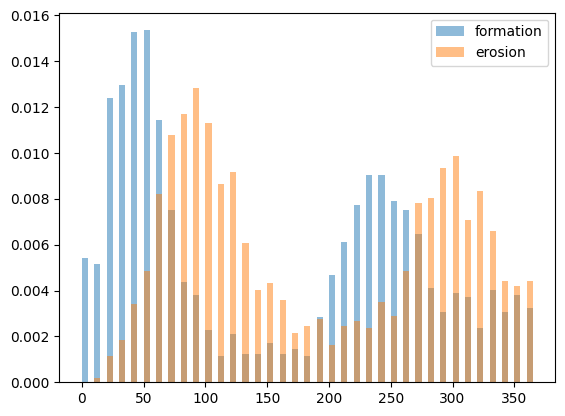

In [18]:
_=plt.hist(pd.to_datetime(np.concatenate(timestart)).dayofyear, bins=np.arange(0,366,5), density=True, alpha=0.5,label='formation')
_=plt.hist(np.array(pd.to_datetime(np.concatenate(timestart)).dayofyear)+np.concatenate(length), bins=np.arange(0,366,5), density=True, alpha=0.5,label='erosion')
plt.legend()

## Annual cycle of presence laitudinal hovmoler

In [19]:
## presence gridded by latitude
XX, YY=np.meshgrid(np.arange(0,len(dff_presence.time_f)), dff_presence.platform_num_f)
np.shape(XX)

mld_grid0=grid2d(dff_presence.latitude_f.values.flatten(), XX.flatten(), dff_presence_0.presence_mwl_f.values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(dff_presence.time_f), 1), fn='sum')[0]
mld_grid1=grid2d(dff_presence.latitude_f.values.flatten(), XX.flatten(), dff_presence_1.presence_mwl_f.values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(dff_presence.time_f), 1), fn='sum')[0]
mld_grid2=grid2d(dff_presence.latitude_f.values.flatten(), XX.flatten(), dff_presence_2.presence_mwl_f.values.flatten(),xi=np.arange(0,30,0.5), yi=np.arange(0,len(dff_presence.time_f), 1), fn='sum')[0]

df_per_lat= xr.Dataset(
    data_vars=dict(
        mld0=(["time", "latitude"], mld_grid0),
        mld1=(["time", "latitude"], mld_grid1),
        mld2=(["time", "latitude"], mld_grid2)
        
        # mixed_layer_depth=("profile_num", dff.mld.values  ), 
        # time=("profile_num", taxis ),
    ),
    coords=dict(
        latitude=np.arange(0,30,0.5),
        time=dff_presence.time_f.values,
    ),)



summ_=df_per_lat.groupby('time.dayofyear').sum()
sum_toot=(summ_.mld0+summ_.mld1+summ_.mld2).T

per0=summ_.mld0.T/sum_toot
per1=summ_.mld1.T/sum_toot
per2=summ_.mld2.T/sum_toot

summ_=df_per_lat.groupby('time.week').sum()
sum_toot=(summ_.mld0+summ_.mld1+summ_.mld2).T

per0w=summ_.mld0.T/sum_toot
per1w=summ_.mld1.T/sum_toot
per2w=summ_.mld2.T/sum_toot

/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


### correlated with B, winds and formation day

In [20]:
dB_rolled_resamp=df_arg.B.rolling(time=60, center=True).mean()
d_roll_lat=df_arg.latitude_era.rolling(time=60, center=True).mean()
d_roll_lon=df_arg.longitude_era.rolling(time=60, center=True).mean()
msk_dq_nan=np.isfinite(dB_rolled_resamp).astype(float)
msk_dq_nan=msk_dq_nan.where(msk_dq_nan==1, np.nan)
dB_rolled_resamp_mks=dB_rolled_resamp.where(dB_rolled_resamp>0, -1)*msk_dq_nan
dB_rolled_resamp_mks=dB_rolled_resamp_mks.where(dB_rolled_resamp_mks<0, 1)*msk_dq_nan

B_change_sign=dB_rolled_resamp_mks.diff('time').where(dB_rolled_resamp_mks.diff('time')!=0, drop=True)

In [21]:
positive_, negative_, lat_chpos,lat_chneg , lon_chpos,lon_chneg , platform_num_pos, platform_num_neg=[],[], [],[],[],[], [], []

for i in range(len(B_change_sign.platform_num_f)):
    dss=B_change_sign.isel(platform_num_f=i).dropna('time')
    platform_num_pos.append(np.ones(len(dss.time[dss>0].values))*i)
    platform_num_neg.append(np.ones(len(dss.time[dss<0].values))*i)
    positive_.append(dss.time[dss>0].values)
    negative_.append(dss.time[dss<0].values)
    lat_chpos.append(d_roll_lat.isel(platform_num_f=i).sel(time=dss.time[dss>0].values).values)
    lat_chneg.append(d_roll_lat.isel(platform_num_f=i).sel(time=dss.time[dss<0].values).values)  
    lon_chpos.append(d_roll_lon.isel(platform_num_f=i).sel(time=dss.time[dss>0].values).values)
    lon_chneg.append(d_roll_lon.isel(platform_num_f=i).sel(time=dss.time[dss<0].values).values)   

    
dBchange= xr.Dataset(
    data_vars=dict(
        positive_=("platform_num_pos", np.concatenate(positive_)),     
        lat_chpos=("platform_num_pos", np.concatenate(lat_chpos)),       
        lon_chpos=("platform_num_pos", np.concatenate(lon_chpos)),        
        negative_=("platform_num_neg", np.concatenate(negative_)),        
        lat_chneg=("platform_num_neg", np.concatenate(lat_chneg)),        
        lon_chneg=("platform_num_neg", np.concatenate(lon_chneg)),        

        # mixed_layer_depth=("profile_num", dff.mld.values  ), 
        # time=("profile_num", taxis ),
    ),
    coords=dict(
        platform_num_pos=np.concatenate(platform_num_pos),
        platform_num_neg=np.concatenate(platform_num_neg),
        
    ),)

dBchange['positive__dayofyear']=dBchange.positive_.dt.week
dBchange['negative__dayofyear']=dBchange.negative_.dt.week


/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


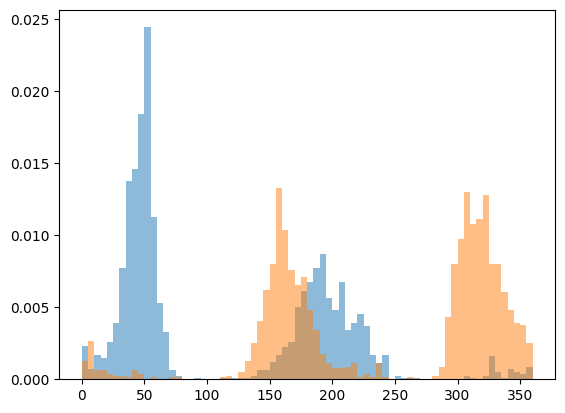

In [22]:
_=plt.hist(pd.to_datetime(np.concatenate(positive_)).dayofyear, bins=np.arange(0,365,5), alpha=0.5, density=True)
_=plt.hist(pd.to_datetime(np.concatenate(negative_)).dayofyear, bins=np.arange(0,365,5), alpha=0.5, density=True)

In [23]:
from scipy.interpolate import interp1d
def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

### Figure 4: hovlolers forcing

13
[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0]
[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0]
13


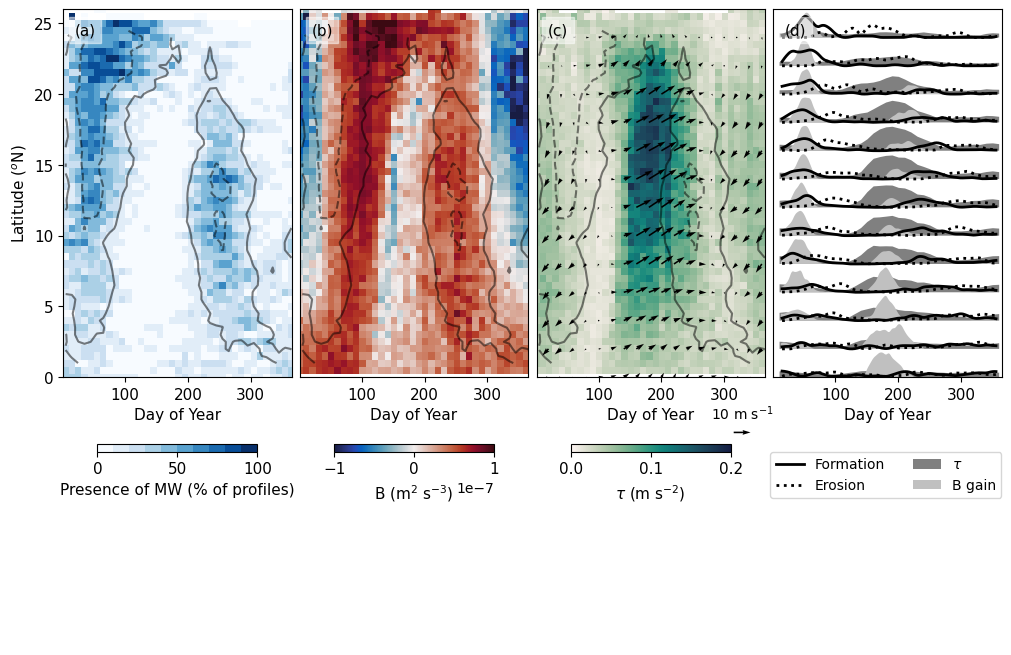

In [25]:
fnt = 11  # Define font size for labels and ticks
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alp=0.5


fig = plt.figure(figsize=(10, 5), constrained_layout=True)

# First subplot
ax1 = plt.subplot(141)
t = ax1.text(x=0.05, y=0.93, s="(" + letters[0] + ')', fontsize=fnt, transform=ax1.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

lol = df_per_lat.groupby('time.dayofyear').mean().groupby_bins('dayofyear', bins=np.arange(0, 365, 10)).mean()
plt.pcolormesh(np.arange(0, 365, 10) + 5, lol.latitude, (per1) * 100, vmin=0, vmax=100, cmap=plt.get_cmap('Blues', 10))
cb = plt.colorbar(shrink=0.7, orientation='horizontal')
plt.contour(np.arange(0, 365, 10) + 5, lol.latitude, (per1).rolling(latitude=5, center=True).mean().rolling(dayofyear=1, center=True).mean() * 100, levels=[20, 50], colors=['k'], alpha=0.5, linestyles=['-', '--'])

cb.set_label('Presence of MW (% of profiles)', fontsize=fnt)

cb.ax.tick_params(labelsize=fnt)  # Update colorbar tick labels font size

plt.ylabel('Latitude ($^o$N)', fontsize=fnt)
plt.xlabel('Day of Year', fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.ylim(0, 26)
plt.xlim(1, 365)

# Second subplot
ax2 = plt.subplot(142)
t = ax2.text(x=0.05, y=0.93, s="(" + letters[1] + ')', fontsize=fnt, transform=ax2.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude + 0.5, qnet_per_lat.groupby('time.dayofyear').mean().B.T, vmin=-1e-7, vmax=1e-7, cmap=cmo.balance)
cb = plt.colorbar(shrink=0.7, orientation='horizontal')
cb.ax.tick_params(labelsize=fnt)  # Update colorbar tick labels font size

plt.contour(np.arange(0, 365, 10) + 5, lol.latitude, (per1).rolling(latitude=5, center=True).mean().rolling(dayofyear=1, center=True).mean() * 100, levels=[20, 50], colors=['k'], alpha=0.5, linestyles=['-', '--'])

cb.set_label('B (m$^{2}$ s$^{-3}$)', fontsize=fnt)
plt.xlabel('Day of Year', fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks([], fontsize=fnt)  # No ticks on the y-axis
plt.ylim(0, 26)
plt.xlim(1, 365)

# Third subplot
ax3 = plt.subplot(143)
t = ax3.text(x=0.05, y=0.93, s="(" + letters[2] + ')', fontsize=fnt, transform=ax3.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.pcolormesh(qnet_per_lat.groupby('time.dayofyear').mean().dayofyear, qnet_per_lat.groupby('time.dayofyear').mean().latitude + 0.5, qnet_per_lat.groupby('time.dayofyear').mean().tau.T, vmin=0, vmax=0.2, cmap=cmo.tempo)
cb = plt.colorbar(shrink=0.7, orientation='horizontal')
plt.contour(np.arange(0, 365, 10) + 5, lol.latitude, (per1).rolling(latitude=5, center=True).mean().rolling(dayofyear=1, center=True).mean() * 100, levels=[20, 50], colors=['k'], alpha=0.5, linestyles=['-', '--'])
cb.ax.tick_params(labelsize=fnt)  # Update colorbar tick labels font size

QV1 = plt.quiver(np.arange(0, 365 + 20, 20), np.arange(0, 30, 2), grid_udiru, grid_udirv, width=0.007)
plt.quiverkey(QV1, 0.9, -0.15, 10, '10 m s$^{-1}$', coordinates='axes')

cb.set_label(r'$\tau$ (m s$^{-2}$)', fontsize=fnt)
plt.xlabel('Day of Year', fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks([], fontsize=fnt)  # No ticks on the y-axis
plt.ylim(0, 26)
plt.xlim(1, 365)

ax1=plt.subplot(144)
t=ax1.text(x=.05,y=.93,s="(" + letters[3] + ')',fontsize=fnt, transform=ax1.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

lat_binn=np.arange(0,26+2,2)
drange=np.mean(np.diff(lat_binn))
SF = drange*40
dt=10
bins_t=np.arange(0,365+dt,dt)

dff=df_length_mwl.groupby_bins('latitude', bins=lat_binn)
keys_df=list(df_length_mwl.groupby_bins('latitude', bins=lat_binn).groups.keys())
print(len(keys_df))
interval_means = [interval.left for interval in keys_df] # [(interval.left + interval.right) / 2 for interval in keys_df]

for i, m in enumerate(interval_means):
    dss=dff[keys_df[i]].time.dt.dayofyear.values
    if len(dss)>1:
        N, _ = np.histogram(dss, bins=bins_t, density=True)
        plt.fill_between(bins_t[:-1]+dt/2, SF * N + float(m), +float(m), color="g", alpha=0)
        plt.plot(np.arange(1,366,1),pd.DataFrame(interp(bins_t[:-1]+dt/2,SF * N + float(m) ,np.arange(1,366,1))).rolling(20, center=True).mean()[0].to_numpy(),lw=2, c="k",  label='Formation' if i==0 else "")
        

for i, m in enumerate(interval_means):
    # print(i)
    dss=(dff[keys_df[i]].time.dt.dayofyear.values+dff[keys_df[i]].length.values)
    if len(dss)>1:
        N, _ = np.histogram(dss, bins=bins_t, density=True)
        plt.fill_between(
            bins_t[1:], SF * N + float(m), +float(m), color="r", alpha=0
        )
        # plt.plot(bins_t[1:], SF * N + float(m), "-w", lw=1)
        plt.plot(np.arange(1,366,1),pd.DataFrame(interp(bins_t[:-1]+dt/2,SF * N + float(m) ,np.arange(1,366,1))).rolling(20, center=True).mean()[0].to_numpy(),lw=2,c='k', ls=':', label='Erosion' if i==0 else "")
        

interval_means = [(interval.left + interval.right) / 2 for interval in keys_df]
print(interval_means)
interval_means = [(interval.left + interval.right) / 2 for interval in keys_df]
print(interval_means)

        

SF=10
dff=qnet_per_lat.groupby('time.dayofyear').mean().tau.groupby_bins('latitude', bins=lat_binn)
keys_df=list(dff.groups.keys())
interval_means = [interval.left for interval in keys_df] # [(interval.left + interval.right) / 2 for interval in keys_df]

for i, m in enumerate(interval_means):
    dss=dff[keys_df[i]].mean('latitude')
    plt.fill_between(dss.dayofyear, np.zeros(len(pd.DataFrame(SF * dss + float(m)).rolling(2,center=True).mean()[0].to_numpy()))+float(m), pd.DataFrame(SF * dss + float(m)).rolling(2,center=True).mean()[0].to_numpy(), color='gray', alpha=1, edgecolor=None, label=r'$\tau$' if i==0 else "")    
    
plt.xlim(1,365)
plt.ylim(0,26)

plt.yticks([])
plt.xlabel('Day of Year', fontsize=fnt)
plt.xticks(fontsize=fnt)


#######
drange=np.mean(np.diff(lat_binn))
SF = 1.75
dt=5
bins_t=np.arange(0,365+dt,dt)

dff=dBchange.groupby_bins('lat_chpos', bins=lat_binn)
keys_df=list(dBchange.groupby_bins('lat_chpos', bins=lat_binn).groups.keys())
print(len(keys_df))
interval_means = [interval.left for interval in keys_df] # [(interval.left + interval.right) / 2 for interval in keys_df]

for i, m in enumerate(interval_means):
    # print(i)
    dss=dff[keys_df[i]].positive_.dt.dayofyear.values
    if len(dss)>3:
        N, _ = np.histogram(dss, bins=bins_t, density=True)
        plt.fill_between(
            bins_t[:-1]+dt/2, SF * N + float(m), +float(m), color="gray", alpha=0)

        to_plt=pd.DataFrame(interp(bins_t[:-1]+dt/2, N  ,np.arange(1,366,1))).rolling(20, center=True).mean()[0].to_numpy()
        plt.fill_between(np.arange(1,366,1), np.zeros(len(to_plt))+float(m),SF*(to_plt/np.nanmax(to_plt))+ float(m), color='silver', alpha=1, edgecolor=None, label='B gain' if i==0 else "")    
        

legend_ax = fig.add_axes([0.83, -0.28, 0.1, 0.68], frame_on=False)  # Adjust the position and size as needed
legend_ax.axis('off')  # Turn off the axis
lines = []
labels = []
# for ax in axs.flat:
line, label = ax1.get_legend_handles_labels()
lines.extend(line)
labels.extend(label)

legend_ax.legend(lines, labels,  loc='center', ncol=2)
plt.savefig('Figures/Figure4_ForcingERA5.png', dpi=600, bbox_inches='tight')

## Maps of presnece and length per week & month

In [26]:
dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='week', gs=GS) ##3min

dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='week', gs=GS) ##3min

dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='week', gs=GS) ##3min

percentage0=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)

/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


In [27]:
dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='month', gs=GS) ##3min

dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='month', gs=GS) ##3min

dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='month', gs=GS) ##3min

percentage0_mn=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1_mn=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2_mn=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)

#### map per %

Text(0.5, 0, 'Longitude (E)')

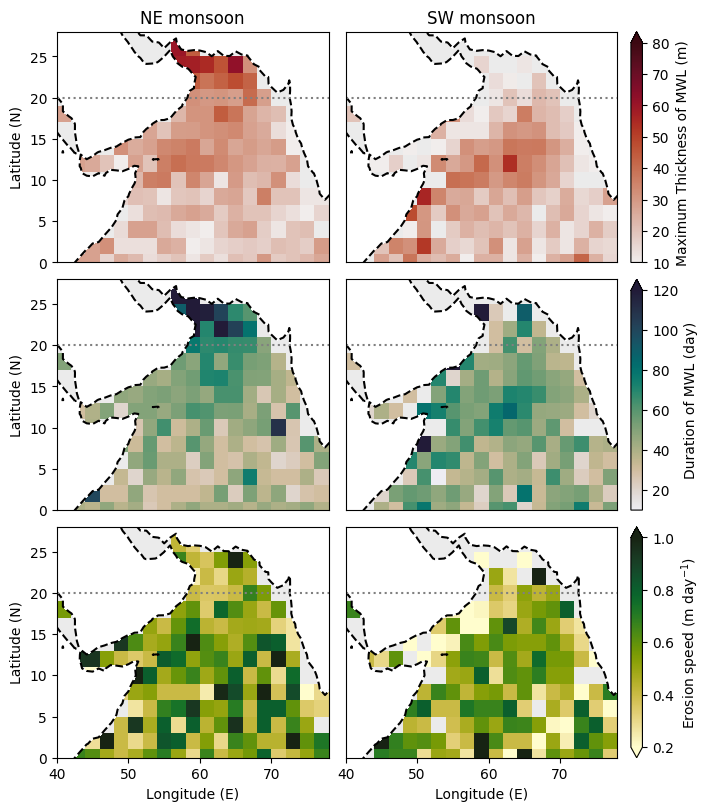

In [28]:
GS=2
latt=np.arange(-5,30+GS,GS)
lonn=np.arange(30,80+GS,GS)
# grid 3d for 3d variables (2d + time)

plt.figure(figsize=(7,8), constrained_layout=True)
plt.subplot(321)
plt.title('NE monsoon')

a1,b,c=grid2d(NW_m.longitude, NW_m.latitude,(NW_m.set_coords(['latitude', 'longitude']).thickness), xi=lonn, yi=latt, fn='mean')
# a1=pd.DataFrame(a1).interpolate(limit=3, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).rolling(3, center=True).mean().rolling(3, center=True, axis=1).mean()
a1=pd.DataFrame(a1)#.interpolate(limit=3, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).rolling(3, center=True).mean().rolling(3, center=True, axis=1).mean()

cmap = cl.ListedColormap(['w', 'silver'])

cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, (a1.fillna(0)==0), cmap=cmap, alpha=0.3)

cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, a1, vmin=10, vmax=80, cmap=cmo.amp)

plt.xticks([])
plt.ylabel('Latitude (N)')

# plt.colorbar() 
# p# cb=plt.colorbar(orientation='horizontal', extend='max')
# cb.set_label('% of year with subsurface mode water')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k')
plt.xlim(40,78)
plt.ylim(0,28)
plt.axhline(20, ls=':', c='gray')

plt.subplot(322)
plt.title('SW monsoon')
plt.xticks([])

a2,b,c=grid2d(SW_m.longitude, SW_m.latitude,(SW_m.set_coords(['latitude', 'longitude']).thickness), xi=lonn, yi=latt, fn='mean')
a2=pd.DataFrame(a2)

cmap = cl.ListedColormap(['w', 'silver'])
cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, (a2.fillna(0)==0), cmap=cmap, alpha=0.3)

cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, a2,  vmin=10, vmax=80, cmap=cmo.amp)
# plt.colorbar() 
cb=plt.colorbar(extend='max')
cb.set_label('Maximum Thickness of MWL (m)')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k')
plt.xlim(40,78)
plt.ylim(0,28)
plt.axhline(20, ls=':', c='gray')
plt.yticks([])

plt.subplot(323)
# plt.title('NE monsoon')

a3,b,c=grid2d(NW_m.longitude, NW_m.latitude,(NW_m.set_coords(['latitude', 'longitude']).length), xi=lonn, yi=latt, fn='mean')
a3=pd.DataFrame(a3)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

cmap = cl.ListedColormap(['w', 'silver'])
cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, (a3.fillna(0)==0), cmap=cmap, alpha=0.3)

cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, a3, vmin=10, vmax=120, cmap=cmo.rain)

plt.xticks([])
plt.ylabel('Latitude (N)')

# plt.colorbar() 
# p# cb=plt.colorbar(orientation='horizontal', extend='max')
# cb.set_label('% of year with subsurface mode water')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k')
plt.xlim(40,78)
plt.ylim(0,28)
plt.axhline(20, ls=':', c='gray')

plt.subplot(324)
# plt.title('SW monsoon')
a4,b,c=grid2d(SW_m.longitude, SW_m.latitude,(SW_m.set_coords(['latitude', 'longitude']).length), xi=lonn, yi=latt, fn='mean')
a4=pd.DataFrame(a4)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

cmap = cl.ListedColormap(['w', 'silver'])
cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, (a4.fillna(0)==0), cmap=cmap, alpha=0.3)

cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, a4, vmin=10, vmax=120, cmap=cmo.rain)
# plt.colorbar() 
cb=plt.colorbar(extend='max')
cb.set_label('Duration of MWL (day)')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k')
plt.xlim(40,78)
plt.ylim(0,28)
plt.axhline(20, ls=':', c='gray')
plt.yticks([])
plt.xticks([])

plt.subplot(325)
# plt.title('NE monsoon')


a,b,c=grid2d(NW_m.longitude, NW_m.latitude,(NW_m.set_coords(['latitude', 'longitude']).thickness)/(NW_m.set_coords(['latitude', 'longitude']).length), xi=lonn, yi=latt, fn='median')


# a,b,c=grid2d(NW_m.longitude, NW_m.latitude,(NW_m.set_coords(['latitude', 'longitude']).speed), xi=lonn, yi=latt, fn='median')
# a11=pd.DataFrame(a1)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()
# a33=pd.DataFrame(a3)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

# a=pd.DataFrame(a11/a33)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

# a1,b,c=grid2d(NW_m.longitude, NW_m.latitude,(NW_m.set_coords(['latitude', 'longitude']).thickness), xi=lonn, yi=latt, fn='median')
# a2,b,c=grid2d(NW_m.longitude, NW_m.latitude,(NW_m.set_coords(['latitude', 'longitude']).length), xi=lonn, yi=latt, fn='median')
# a=(a1/a2)
a=pd.DataFrame(a)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

cmap = cl.ListedColormap(['w', 'silver'])
cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, (a1.fillna(0)==0), cmap=cmap, alpha=0.3)

cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, a, vmin=0.2, vmax=1 , cmap=cmo.speed)


# plt.colorbar() 
# p# cb=plt.colorbar(orientation='horizontal', extend='max')
# cb.set_label('% of year with subsurface mode water')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k')
plt.xlim(40,78)
plt.ylim(0,28)
plt.axhline(20, ls=':', c='gray')
plt.xlabel('Longitude (E)')
plt.ylabel('Latitude (N)')
plt.subplot(326)
# plt.title('SW monsoon')
a,b,c=grid2d(SW_m.longitude, SW_m.latitude,(SW_m.set_coords(['latitude', 'longitude']).thickness)/(SW_m.set_coords(['latitude', 'longitude']).length), xi=lonn, yi=latt, fn='median')

# a,b,c=grid2d(SW_m.longitude, SW_m.latitude,(SW_m.set_coords(['latitude', 'longitude']).speed), xi=lonn, yi=latt, fn='median')
# a22=pd.DataFrame(a2)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()
# a44=pd.DataFrame(a4)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

# a=pd.DataFrame(a22/a44)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

# a=pd.DataFrame(a2/a4)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0).to_numpy()

# a1,b,c=grid2d(SW_m.longitude, SW_m.latitude,(SW_m.set_coords(['latitude', 'longitude']).thickness), xi=lonn, yi=latt, fn='median')
# a2,b,c=grid2d(SW_m.longitude, SW_m.latitude,(SW_m.set_coords(['latitude', 'longitude']).length), xi=lonn, yi=latt, fn='median')
# a=(a1/a2)
a=pd.DataFrame(a)#.interpolate(limit=1, limit_area='inside' ,axis=1).interpolate(limit=1, limit_area='inside' ,axis=0)#.rolling(3, center=True).mean().rolling(3, center=True, axis=1).mean()#.to_numpy()


cmap = cl.ListedColormap(['w', 'silver'])
cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, (a2.fillna(0)==0), cmap=cmap, alpha=0.3)

cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, a, vmin=0.2, vmax=1 , cmap=cmo.speed)
# cb=plt.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, a, norm=cl.LogNorm(0.25,2), cmap=cmo.speed)
# plt.colorbar() 
cb=plt.colorbar(extend='both')
cb.set_label('Erosion speed (m day$^{-1}$)')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k')
plt.xlim(40,78)
plt.ylim(0,28)
plt.axhline(20, ls=':', c='gray')
plt.yticks([])
plt.xlabel('Longitude (E)')

In [70]:
#north AS
print( np.nanmedian(((df_length_mwl.set_coords(['latitude', 'longitude']).thickness/df_length_mwl.set_coords(['latitude', 'longitude']).length)).where(df_length_mwl.latitude>20, drop=True)))
#north AS
print( np.nanstd(((df_length_mwl.set_coords(['latitude', 'longitude']).thickness/df_length_mwl.set_coords(['latitude', 'longitude']).length)).where(df_length_mwl.latitude>20, drop=True)))

0.4235294117647059
0.4126823451680793


In [71]:
#south AS in winter
print(np.nanmedian(((NW_m.set_coords(['latitude', 'longitude']).thickness/NW_m.set_coords(['latitude', 'longitude']).length)).where(NW_m.latitude<20, drop=True)))
print(np.nanstd(((NW_m.set_coords(['latitude', 'longitude']).thickness/NW_m.set_coords(['latitude', 'longitude']).length)).where(NW_m.latitude<20, drop=True)))


0.5333333333333333
0.4387965552654688


In [72]:
#south AS in summer
print(np.nanmedian(((SW_m.set_coords(['latitude', 'longitude']).thickness/SW_m.set_coords(['latitude', 'longitude']).length)).where(SW_m.latitude<20, drop=True)))
print( np.nanstd(((SW_m.set_coords(['latitude', 'longitude']).thickness/SW_m.set_coords(['latitude', 'longitude']).length)).where(SW_m.latitude<20, drop=True)))

0.5
0.3982844828910535


### Figure 3 - MW length and thickness

In [29]:
GS=1
latt=np.arange(-5,30+GS,GS)
lonn=np.arange(30,80+GS,GS)

latt1=latt[:-1]+GS/2
lonn1=lonn[:-1]+GS/2

df_grid_thickness_fmtnh['latitude_f_bins']=latt1
df_grid_thickness_fmtnh['longitude_f_bins']=lonn1

df_grid_thickness_f['latitude_f_bins']=latt1
df_grid_thickness_f['longitude_f_bins']=lonn1

# cn, cs=["#920048","#94ba2e"]
# cn, cs=["#a84a9f", "#bbb7b4"]
cn, cs=["#a60021",
"#81a35e"]

In [30]:
#season

def grid_lat_3dfsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_fsum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dfsum)
    
    
def grid_var_3dfltsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time_f.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_fsum)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_fsum)
    return var


dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='season', gs=1)
dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='season', gs=1) 
dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='season', gs=1) 

percentage0_seas=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1_seas=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2_seas=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)

#month

In [31]:
#month
dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='month', gs=1) ##3min
dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='month', gs=1) ##3min
dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='month', gs=1) ##3min

percentage0_mn=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1_mn=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2_mn=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)

In [32]:
msk_availability_data_season=np.isfinite((percentage0_mn+percentage1_mn+percentage2_mn)).astype(float)
msk_availability_data_season=((percentage0_mn+percentage1_mn+percentage2_mn)>0).astype(float)
cmap_data_availability_ = cl.ListedColormap(['white', 'midnightblue'])


## PLOR

In [33]:
# from matplotlib.gridspec import GridSpec
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
monthss = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

alp=0.5


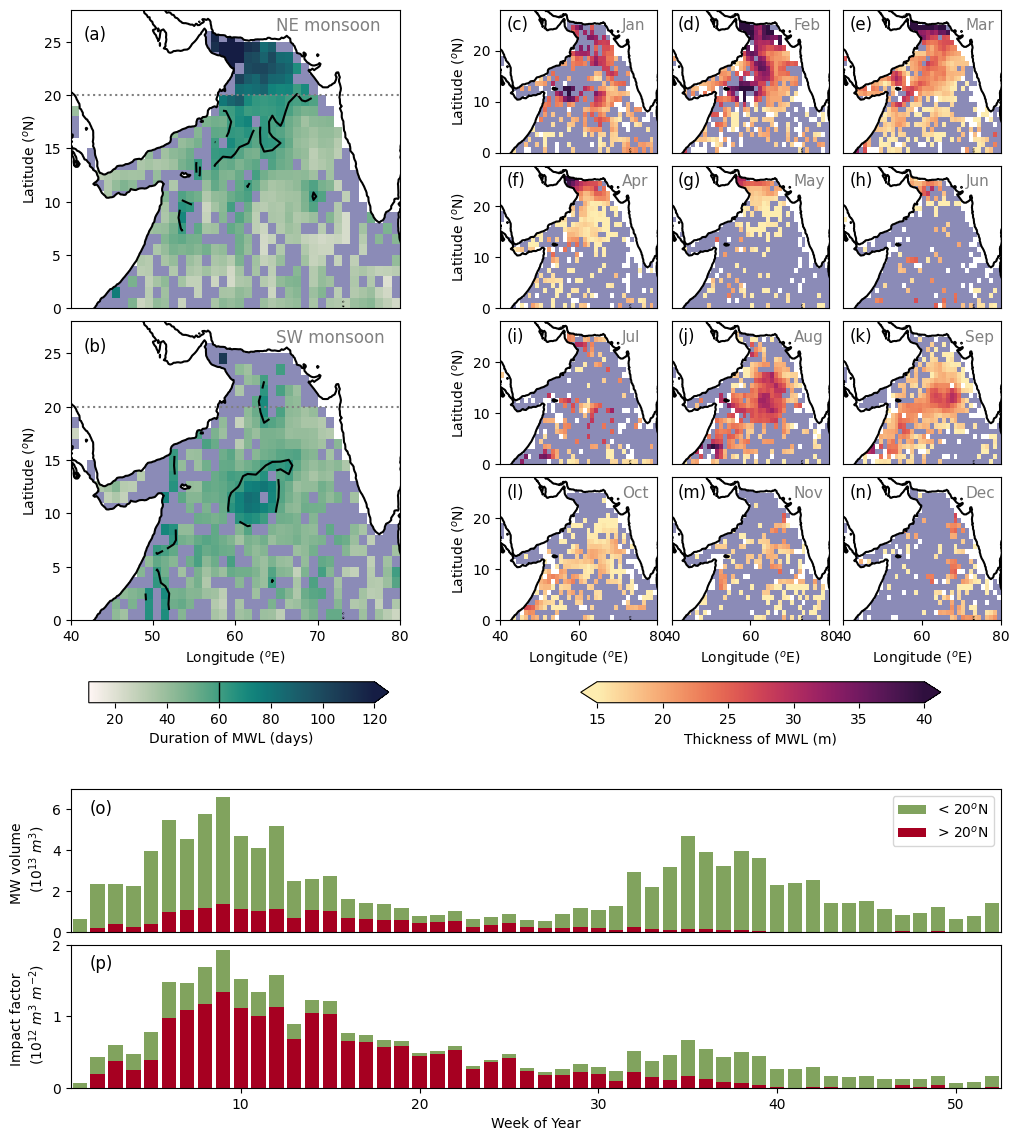

In [34]:
cmap_data_availability_time = cl.ListedColormap(['white', 'midnightblue'])


fig=plt.figure(figsize=(12,14))


gs = GridSpec(14,11, figure=fig)

ax = fig.add_subplot(gs[0:4, 0:4])
t=ax.text(x=.04,y=.9,s="(" + letters[0] + ')',fontsize=12, transform=ax.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ax.text(65, 26, 'NE monsoon', fontsize=12, c='gray')
a,b,c=grid2d(NW_m.longitude, NW_m.latitude, NW_m.length, xi=lonn, yi=latt, fn='median')

dss_interp=pd.DataFrame(a).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()/(pd.DataFrame(a)/pd.DataFrame(a))
# dss_interp=dss_interp.interpolate(axis=1, limit=1, limit_area='inside')
mskk_availability_data_m=msk_availability_data_season[:6].sum('month').where(msk_availability_data_season.sum('month')==0, 1)
ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_time, alpha=0.5)

cb=ax.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, dss_interp, vmin=10, vmax=120, cmap=cmo.tempo)
ax.contour(lonn[:]+GS/2,latt[:]+GS/2, dss_interp, levels=[60], colors='k')

# cb=plt.colorbar(cb, orientation='horizontal', extend='max')
# cb.set_label('maximum mode water thickn')
ax.contourf(ds_bath.lon[::50],ds_bath.lat[::50], ds_bath.elevation[::50, ::50],  levels=[-1,3000], colors='white')
ax.contour(ds_bath.lon[::50],ds_bath.lat[::50], ds_bath.elevation[::50, ::50],  levels=[-1], colors='k', linestyles='solid')
ax.set_xlim(40,80)
ax.set_ylim(0,28)
ax.axhline(20, c='gray', ls=':')
ax.set_ylabel('Latitude ($^o$N)')
ax.set_xticks([])

ax = fig.add_subplot(gs[4:4+4, 0:4])

t=ax.text(x=.04,y=.9,s="(" + letters[1] + ')',fontsize=12, transform=ax.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ax.text(65, 26, 'SW monsoon', fontsize=12, c='gray')
a,b,c=grid2d(SW_m.longitude, SW_m.latitude, SW_m.length, xi=lonn, yi=latt)
dss_interp=pd.DataFrame(a).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()/(pd.DataFrame(a)/pd.DataFrame(a))
# dss_interp=dss_interp.interpolate(axis=1, limit=1, limit_area='inside')
mskk_availability_data_m=msk_availability_data_season[6:].sum('month').where(msk_availability_data_season.sum('month')==0, 1)
ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_time, alpha=0.5)

cb=ax.pcolormesh(lonn[:]+GS/2,latt[:]+GS/2, dss_interp, vmin=10, vmax=120, cmap=cmo.tempo)
ax.contour(lonn[:]+GS/2,latt[:]+GS/2, dss_interp, levels=[60], colors='k')


# cb=ax.pcolormesh(b,c,a, vmin=0, vmax=120, cmap=cmo.tempo)
ax.contourf(ds_bath.lon[::50],ds_bath.lat[::50], ds_bath.elevation[::50, ::50],  levels=[-1,3000], colors='white')
ax.contour(ds_bath.lon[::50],ds_bath.lat[::50], ds_bath.elevation[::50, ::50],  levels=[-1], colors='k', linestyles='solid')
ax.set_xlim(40,80)
ax.set_ylim(0,28)
ax.axhline(20, c='gray', ls=':')
ax.set_xlabel('Longitude ($^o$E)')
ax.set_ylabel('Latitude ($^o$N)')


cbaxes = fig.add_axes([0.14, 0.385, 0.25, 0.015]) 
cbb=plt.colorbar(cb, cax=cbaxes, orientation='horizontal', extend= 'max')
cbb.set_label('Duration of MWL (days)')
# Get the data limits of the colorbar
vmin, vmax = cb.get_clim()  # Get the color limits of your mappable object
line_value = 60  # The value where you want to draw the line

# Normalize the value to the colorbar range [vmin, vmax]
normalized_value = (line_value - vmin) / (vmax - vmin)

# Calculate the x-coordinate for the vertical line
x_pos = normalized_value * (cbaxes.get_xlim()[1] - cbaxes.get_xlim()[0]) + cbaxes.get_xlim()[0]

# Draw the vertical line at the normalized position
cbaxes.vlines(x=x_pos, ymin=cbaxes.get_ylim()[0], ymax=cbaxes.get_ylim()[1], colors='black', linewidth=1)





iss1=np.array([2,4,6,2,4,6,2,4,6, 2,4,6])+3
# iss2=iss1+2
jss1=[0,0,0,2,2,2,4,4,4,6,6,6]
# jss2=jss1+2


axis=[]
df2=df_grid_thickness_fmtnh
for i in range(12):

    ax = fig.add_subplot(gs[jss1[i]:jss1[i]+2, iss1[i]:iss1[i]+2])
    # ax = fig.add_subplot(axiss[i])
    t=ax.text(x=.04,y=.86,s="(" + letters[2+i] + ')',fontsize=12, transform=ax.transAxes)
    # t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    mskk_availability_data_m=msk_availability_data_season.isel(month=i)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis.append(ax)
    ax.text(71, 24, monthss[i], fontsize=11, c='gray')
    # ax.pcolormesh(lonn, latt, ((to_p1>0.5)*mskk).T, cmap=cmap, alpha=0.5)
    
    to_p2=df2.isel(month=i)
    
#     pltlol=to_p2.copy()
#     pltlol=pltlol.where(pltlol!=0, np.nan)
    
#     msk1=np.isfinite(pltlol).astype(float)
#     msk1=msk1.where(msk1!=0, np.nan)
#     df_plt=pltlol.interpolate_na(dim='longitude_f_bins', method='linear', fill_value="extrapolate",limit=5).interpolate_na(dim='latitude_f_bins',fill_value="extrapolate", method='linear', limit=5).rolling(longitude_f_bins=3, center=True).mean().rolling(latitude_f_bins=3, center=True).mean()*msk1
    dss_interp=pd.DataFrame((to_p2.values)).interpolate(axis=0, limit_direction='both', limit=5).interpolate(axis=1, limit_direction='both', limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()/(pd.DataFrame(to_p2.values)/pd.DataFrame(to_p2.values))

    # mks=np.isfinite(to_p2.T).astype(float)
    # mks[mks==0]=np.nan
    # cb=plt.pcolormesh(lonn, latt, pd.DataFrame(to_p2.T).interpolate(limit=3, axis=1).interpolate(limit=3, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks, cmap=cmo.matter, vmin=10, vmax=40)

    cb=ax.pcolormesh(lonn, latt, (dss_interp).T, cmap=cmo.matter, vmin=15, vmax=40)
    ax.contourf(ds_bath.lon[::50],ds_bath.lat[::50], ds_bath.elevation[::50, ::50],  levels=[-1,3000], colors='white')
    ax.contour(ds_bath.lon[::50],ds_bath.lat[::50], ds_bath.elevation[::50, ::50],  levels=[-1], colors='k', linestyles='solid')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)

for ais in axis[0:9]:
    ais.set_xticks([])

for ais in axis[1:3]:
    ais.set_yticks([])
for ais in axis[4:6]:
    ais.set_yticks([])
for ais in axis[7:9]:
    ais.set_yticks([])
for ais in axis[10:]:
    ais.set_yticks([])
    
for ais in [axis[0],axis[3],axis[6],axis[9]]:
    ais.set_ylabel('Latitude ($^o$N)')
    
for ais in axis[9:]:
    ais.set_xlabel('Longitude ($^o$E)')
    

cbaxes = fig.add_axes([0.6-0.05, 0.385, 0.3, 0.015]) 
cbb=plt.colorbar(cb, cax=cbaxes, orientation='horizontal', extend= 'both')
cbb.set_label('Thickness of MWL (m)')





ax1 = fig.add_subplot(gs[10:12, :])
t=ax1.text(x=.02,y=.83,s="(" + letters[14] + ')',fontsize=12, transform=ax1.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

# ax1=plt.axes()
# ax1.bar(dff_presence_1_f_grid_mean.week , (dff_presence_1_f_grid_mean).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2))
# plt.colorbar()
ax1.bar(df_grid_thickness_f.week , (df_grid_thickness_f).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2), color=cs, label='< 20$^o$N')
ax1.bar(df_grid_thickness_f.week , df_grid_thickness_f.where(df_grid_thickness_f.latitude_f_bins>20).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2), color=cn, label='> 20$^o$N') #dff_presence_1_f_grid_mean.latitude_f_bins[latt>20]

ax1.set_ylabel('MW volume \n (10$^{13}$ $m^3 $)', c='k')
# ax1.set_xlabel('Week of Year')
ax1.set_xticks([])

ax1.legend(loc=1)
ax1.set_xlim(0.5,52.5)
ax1.set_ylim(0,7e13)

offset_text = ax1.yaxis.get_offset_text()
offset_text.set_visible(False)


ax1 = fig.add_subplot(gs[12:14, :])
t=ax1.text(x=.02,y=.83,s="(" + letters[15] + ')',fontsize=12, transform=ax1.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))


ax1.bar(df_grid_thickness_f.week , (df_grid_thickness_f).where(df_grid_thickness_f.latitude_f_bins>20).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2)/10+(df_grid_thickness_f).where(df_grid_thickness_f.latitude_f_bins<20).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2)/90, color=cs, label='<20$^o$N')
ax1.bar(df_grid_thickness_f.week , df_grid_thickness_f.where(df_grid_thickness_f.latitude_f_bins>20).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2)/10, color=cn, label='> 20$^o$N') #dff_presence_1_f_grid_mean.latitude_f_bins[latt>20]

ax1.set_ylabel('Impact factor \n (10$^{12}$ $m^{3}$ $m^{-2}$)', c='k')
ax1.set_xlabel('Week of Year')
ax1.set_yticks([0,1e12,2e12])
# ax1.legend(loc=1)
ax1.set_xlim(0.5,52.5)
ax1.set_ylim(0,2e12)
# ax1.yaxis.set_tick_params(pad=10)  # Increase padding (default is 4)
offset_text = ax1.yaxis.get_offset_text()
offset_text.set_visible(False)

plt.savefig('Figures/Figure3_ClimatologyThickness.png', dpi=600, bbox_inches='tight')

In [79]:
## SOME STATS!
# df_grid_thickness_f.longitude_f_bins
# 20*(100000**2)*25*25/ 1000000## m3 yr

125000000.0

In [116]:
# winter , summer, all
6.5e13/(100*24*3600)/1000000, 5e13/(100*24*3600)/1000000,  (6.5e13+5e13)/(365*24*3600)/1000000

(7.523148148148148, 5.787037037037037, 3.6466260781329276)

In [119]:
# winter north, winter south
1.7e13/(100*24*3600)/1000000, (6.5-1.7)*10**13/(100*24*3600)/1000000

(1.9675925925925926, 5.555555555555556)

In [113]:
# 6.5e13/(100*24*3600)/1000000, 5e13/(100*24*3600)/1000000

In [104]:
np.mean((df_grid_thickness_f.astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T.diff('week')*(100000**2)/(7*24*3600)))/1000000

<xarray.DataArray 'mw_thickness_f' ()>
array(-0.0667735)

In [45]:
a=(np.sum(df_grid_thickness_f.where(df_grid_thickness_f.latitude_f_bins>20).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2)*7*24*3600))/1000000## m3 yr
b=(np.sum(df_grid_thickness_f.where(df_grid_thickness_f.latitude_f_bins<20).astype(float).sum('longitude_f_bins').sum('latitude_f_bins').T*(100000**2)*7*24*3600))/1000000## m3 yr
a, b

(<xarray.DataArray 'mw_thickness_f' ()>
 array(1.1467008e+14),
 <xarray.DataArray 'mw_thickness_f' ()>
 array(6.00941376e+14))

In [54]:
Sv_winter=(np.sum(df_grid_thickness_f.astype(float).sum('longitude_f_bins').sum('latitude_f_bins').isel(week=slice(0,25)).T*(100000**2)*7*24*3600))/1000000## m3 yr
Sv_summer=(np.sum(df_grid_thickness_f.astype(float).sum('longitude_f_bins').sum('latitude_f_bins').isel(week=slice(25,54)).T*(100000**2)*7*24*3600))/1000000## m3 yr

Sv_winter, Sv_summer , Sv_winter+Sv_summer

(<xarray.DataArray 'mw_thickness_f' ()>
 array(4.0049856e+14),
 <xarray.DataArray 'mw_thickness_f' ()>
 array(3.15112896e+14),
 <xarray.DataArray 'mw_thickness_f' ()>
 array(7.15611456e+14))

In [109]:
a,b,c=grid2d(NW_m.longitude, NW_m.latitude, NW_m.length, xi=lonn, yi=latt, fn='median')

dss_interp=pd.DataFrame(a).interpolate(axis=0, limit=5).interpolate(axis=1, limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()/(pd.DataFrame(a)/pd.DataFrame(a))

print('length nw north')
print(np.nanmean(dss_interp[25:]), np.nanstd(dss_interp[25:]))
print('length nw south')
print(np.nanmean(dss_interp[15:25]), np.nanstd(dss_interp[15:25]))
print('length nw eq')
print(np.nanmean(dss_interp[:15]), np.nanstd(dss_interp[:15]))

print('length nw eqEAST')
print(np.nanmean(dss_interp.values[:15, 30:]), np.nanstd(dss_interp.values[:15, 30:]))

print('length nw eq WEST')
print(np.nanmean(dss_interp.values[:15, :25]), np.nanstd(dss_interp.values[:15, :25]))

a,b,c=grid2d(SW_m.longitude, SW_m.latitude, SW_m.length, xi=lonn, yi=latt, fn='median')

dss_interp=pd.DataFrame(a).interpolate(axis=0, limit=5).interpolate(axis=1, limit=5).rolling( 3,axis=1, center=True).mean().rolling(3, axis=0,center=True).mean()/(pd.DataFrame(a)/pd.DataFrame(a))

print('length sw north')
print(np.nanmean(dss_interp[25:]), np.nanstd(dss_interp[25:]))
print('length sw south')
print(np.nanmean(dss_interp.values[15:25, 25:40]), np.nanstd(dss_interp.values[15:25, 25:40]))
print('length nw eq')
print(np.nanmean(dss_interp.values[:15, 30:]), np.nanstd(dss_interp.values[:15, 30:]))
print('length nw eq')
print(np.nanmean(dss_interp.values[:15, :25]), np.nanstd(dss_interp.values[:15, :25]))


length nw north
94.4753086419753 18.849584982721662
length nw south
49.540351346531125 11.3255160251499
length nw eq
39.91261843345176 10.122937312627988
length nw eqEAST
37.65699085036101 7.803127891781084
length nw eq WEST
45.98713345737155 13.223516415783736
length sw north
49.160493827160494 10.585320102697588
length sw south
51.73477196204468 11.43153904261915
length nw eq
42.75885916780979 8.848130634635739
length nw eq
49.463060065050115 8.636888544139577


In [97]:
# dss_interp.values[dss_interp]

In [110]:
print('NORTH')

print('max depth in north duing nwm')
print(np.nanmean(df_grid_thickness_fmtnh.max('month').T[25:]), np.nanstd(df_grid_thickness_fmtnh.max('month').T[25:]))




print('\n  CENTRAL')

## central all
print('max depth in south duing nwm')
print(np.nanmean(df_grid_thickness_fmtnh[:6].max('month').T[15:25]), np.nanstd(df_grid_thickness_fmtnh[:6].max('month').T[15:25]))

print('max depth in south duing swm')
print(np.nanmean(df_grid_thickness_fmtnh[6:].max('month').T[15:25]), np.nanstd(df_grid_thickness_fmtnh[6:].max('month').T[15:25]))

print('\n  CENTRAL west')

##central west
print('max depth in south duing nwm')
print(np.nanmean(df_grid_thickness_fmtnh[:6].max('month').T[15:25, :25]), np.nanstd(df_grid_thickness_fmtnh[:6].max('month').T[15:25, :25]))

print('max depth in south duing swm')
print(np.nanmean(df_grid_thickness_fmtnh[6:].max('month').T[15:25, :25]), np.nanstd(df_grid_thickness_fmtnh[6:].max('month').T[15:25, :25]))

print('\n  CENTRAL cental')

##central central
print('max depth in south duing nwm')
print(np.nanmean(df_grid_thickness_fmtnh[:6].max('month').T[15:25, 25:40]), np.nanstd(df_grid_thickness_fmtnh[:6].max('month').T[15:25, 25:40]))

print('max depth in south duing swm')
print(np.nanmean(df_grid_thickness_fmtnh[6:].max('month').T[15:25, 25:40]), np.nanstd(df_grid_thickness_fmtnh[6:].max('month').T[15:25, 25:40]))

print('\n  CENTRAL east')

##central east
print('max depth in south duing nwm')
print(np.nanmean(df_grid_thickness_fmtnh[:6].max('month').T[15:25, 40:]), np.nanstd(df_grid_thickness_fmtnh[:6].max('month').T[15:25, 40:]))

print('max depth in south duing swm')
print(np.nanmean(df_grid_thickness_fmtnh[6:].max('month').T[15:25, 40:]), np.nanstd(df_grid_thickness_fmtnh[6:].max('month').T[15:25, 40:]))


print('\n  SOUTH')

##south

print('max depth in equator duing nwm')
print(np.nanmean(df_grid_thickness_fmtnh[:6].max('month').T[:15]), np.nanstd(df_grid_thickness_fmtnh[:6].max('month').T[:15]))

print('max depth in equator duing swm')
print(np.nanmean(df_grid_thickness_fmtnh[6:].max('month').T[:15]), np.nanstd(df_grid_thickness_fmtnh[6:].max('month').T[:15]))


print('Greatwirld')


print(np.nanmean(df_grid_thickness_fmtnh[6:].max('month').T[:15, :25]), np.nanstd(df_grid_thickness_fmtnh[6:].max('month').T[:15, :25]))

print(np.nanmean(df_grid_thickness_fmtnh[6:].max('month').T[:15, 30:]), np.nanstd(df_grid_thickness_fmtnh[6:].max('month').T[:15, 30:]))


NORTH
max depth in north duing nwm
40.666666666666664 15.466243188394948

  CENTRAL
max depth in south duing nwm
28.33009708737864 11.642230084902005
max depth in south duing swm
24.963350785340314 10.20797949237459

  CENTRAL west
max depth in south duing nwm
26.571428571428573 9.561828874675149
max depth in south duing swm
20.307692307692307 9.424882087690216

  CENTRAL cental
max depth in south duing nwm
29.802816901408452 12.329535954519896
max depth in south duing swm
27.134751773049647 10.092634670083598

  CENTRAL east
max depth in south duing nwm
20.133333333333333 5.0841802573166985
max depth in south duing swm
17.25 4.892596447695231

  SOUTH
max depth in equator duing nwm
20.6231884057971 7.57494238611153
max depth in equator duing swm
21.678048780487806 8.931924442219767
Greatwirld
23.565891472868216 10.851960106762489
20.47222222222222 7.394891045867201


In [ ]:
## AREA of AS and impact factor

nas area *100
<xarray.DataArray 'mw_thickness_f' ()>
array(91.28137384)
sas area*100
<xarray.DataArray 'mw_thickness_f' ()>
array(8.71862616)


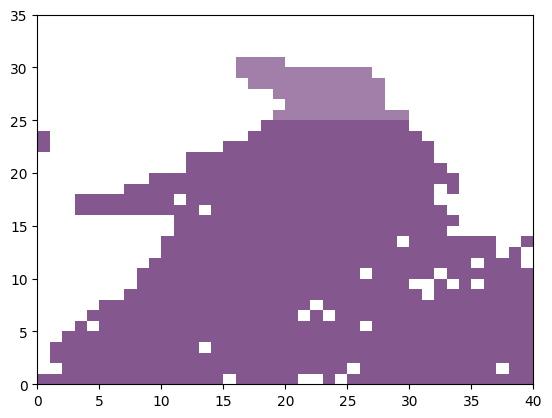

In [168]:
lol_=df_grid_thickness_f.sum('week')
lol_=lol_.where(lol_!=0, np.nan).where(lol_==0, 1)

plt.pcolormesh(lol_.T[:, 10:], alpha=0.5)
plt.pcolormesh(lol_.T[:25, 10:], alpha=0.3)


print('nas area *100')
print(np.sum(lol_.T[:24, 10:])*100/np.sum(lol_.T[:, 10:]))

print('sas area*100')

print(np.sum(lol_.T[24:, 10:])*100/np.sum(lol_.T[:, 10:]))


# 60*100/420, 360*100/420

In [ ]:
## suplementary

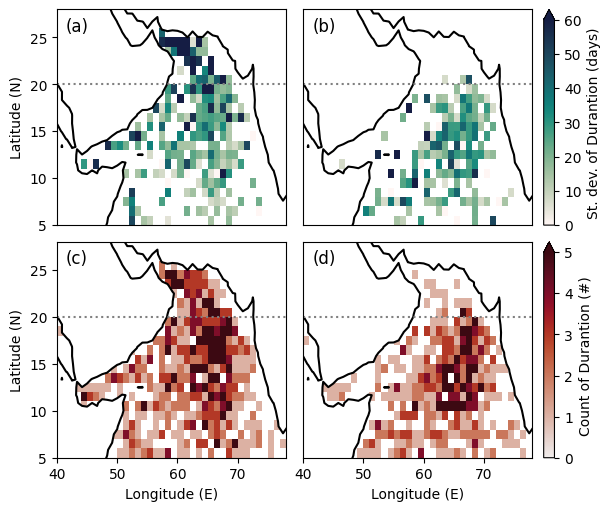

In [37]:
plt.figure(figsize=(6,5), constrained_layout=True)

ax=plt.subplot(221)
t=ax.text(x=.04,y=.9,s="(" + letters[0] + ')',fontsize=12, transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

a,b,c=grid2d(NW_m.longitude, NW_m.latitude, NW_m.length, xi=lonn, yi=latt, fn='std')
cb=plt.pcolormesh(b+GS/2,c+GS/2,a, vmin=0, vmax=60, cmap=cmo.tempo)
plt.ylabel('Latitude (N)')
plt.gca().set_xticks([])

plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k', linestyles='solid')
plt.xlim(40,78)
plt.ylim(5,28)
plt.axhline(20, c='gray', ls=':')


ax=plt.subplot(222)
t=ax.text(x=.04,y=.9,s="(" + letters[1] + ')',fontsize=12, transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

a,b,c=grid2d(SW_m.longitude, SW_m.latitude, SW_m.length, xi=lonn, yi=latt, fn='std')
cb=plt.pcolormesh(b+GS/2,c+GS/2,a, vmin=0, vmax=60, cmap=cmo.tempo)
plt.gca().set_yticks([])
plt.gca().set_xticks([])

cb=plt.colorbar(extend='max')
cb.set_label('St. dev. of Durantion (days)')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k', linestyles='solid')
plt.xlim(40,78)
plt.ylim(5,28)
plt.axhline(20, c='gray', ls=':')

ax=plt.subplot(223)
t=ax.text(x=.04,y=.9,s="(" + letters[2] + ')',fontsize=12, transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

a,b,c=grid2d(NW_m.longitude, NW_m.latitude, NW_m.length, xi=lonn, yi=latt, fn='count')
cb=plt.pcolormesh(b+GS/2,c+GS/2,a, vmin=0, vmax=5, cmap=cmo.amp)
plt.ylabel('Latitude (N)')
plt.xlabel('Longitude (E)')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k', linestyles='solid')
plt.xlim(40,78)
plt.ylim(5,28)
plt.axhline(20, c='gray', ls=':')

# plt.colorbar()

ax=plt.subplot(224)
t=ax.text(x=.04,y=.9,s="(" + letters[3] + ')',fontsize=12, transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

a,b,c=grid2d(SW_m.longitude, SW_m.latitude, SW_m.length, xi=lonn, yi=latt, fn='count')
cb=plt.pcolormesh(b+GS/2,c+GS/2,a, vmin=0, vmax=5, cmap=cmo.amp)
plt.gca().set_yticks([])
cb=plt.colorbar(extend='max')
cb.set_label('Count of Durantion (#)')

plt.xlabel('Longitude (E)')
plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='white')
plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1], colors='k', linestyles='solid')
plt.xlim(40,78)
plt.ylim(5,28)
plt.axhline(20, c='gray', ls=':')

# plt.show()
# cb=plt.contour(b,c,a, levels=[30])
plt.savefig('Figures/SFigure_duration_std_count.png', dpi=600, bbox_inches='tight')